In [181]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
import sys, os, inspect
# Load python source folder
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
srcdir = os.path.join(parentdir, "macega")
if srcdir not in sys.path: sys.path.insert(0, srcdir)
from macega_phasevol import MacegaPhaseEvolve

In [183]:
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
from amuse.units import units, constants

sns.set(font_scale=1.5, rc={'text.usetex' : True})
sns.set_style("ticks")

rsun_to_au = (1 | units.RSun).value_in(units.au)
day_to_yr = (1 | units.day).value_in(units.yr)

In [184]:
def semi_ecc(p, v, m):
    r = (p*p).sum(axis=1)**0.5
    vm2 = (v*v).sum(axis=1)
    E =  vm2 * 0.5 - m / r
    
    h = np.cross(p, v, axis=1)
    evecc = np.cross(v, h, axis=1) / m.reshape((-1,1)) - p / r.reshape((-1,1))
    e = (evecc*evecc).sum(axis=1)**0.5
    a = - m / (2*E)
    
    return a, e
    
def reduce_data(data, Ntrunc):
    MSun = (1 | units.MSun).value_in(units.g)
    au = (1 | units.au).value_in(units.cm)
    yr2pi = (1 | (units.yr / (2*np.pi) )).value_in(units.s)
    day = (1 | units.day).value_in(units.s)

    mass = np.array([data["mass1"], data["mass2"]]) / MSun
    vel = np.array([[data["vx1"], data["vy1"], data["vz1"]], 
                    [data["vx2"], data["vy2"], data["vz2"]]]) * yr2pi / au
    pos = np.array([[data["x1"], data["y1"], data["z1"]], 
                    [data["x2"], data["y2"], data["z2"]]]) / au
    time = data["time"].to_numpy() / day
    
    return time[:Ntrunc], mass.T[:Ntrunc], pos.transpose(2,0,1)[:Ntrunc], vel.transpose(2,0,1)[:Ntrunc]

In [185]:
# Hila Glanz data
datafold = "../data/gdata/"
csvfs = [x for x in os.listdir(datafold) if x.endswith(".csv")]
csvfs.sort()
print(csvfs)
dictecc = {0: 0.2, 1 : 0.5, 2 : 0.7, 3 : 0.0}
N_trunc = [7647, 14412, 73200 , -1]

['02resultCSV.csv', '05resultCSV.csv', '07resultCSV.csv', '0resultCSV.csv']


In [186]:
isim = 1
data = pd.read_csv(datafold+csvfs[isim])
print(data.columns)
data.head(1)

Index(['mass1', 'radius1', 'vx1', 'vy1', 'vz1', 'x1', 'y1', 'z1', 'ax1', 'ay1',
       'az1', 'mass2', 'radius2', 'vx2', 'vy2', 'vz2', 'x2', 'y2', 'z2', 'ax2',
       'ay2', 'az2', 'time'],
      dtype='object')


,mass1,radius1,vx1,vy1,vz1,x1,y1,z1,ax1,ay1,...,vx2,vy2,vz2,x2,y2,z2,ax2,ay2,az2,time
0,2.043933e+33,1.250608e+11,1.069705e+06,3418.063138,-2042.665478,4.217377e+09,-4.712099e+12,-2.512247e+10,0.7495,0.824582,...,-4.266392e+06,-8081.116142,-0.42147,-7.370221e+09,1.866980e+13,-728.091605,0.000199,-1.949509,-0.000102,0.0


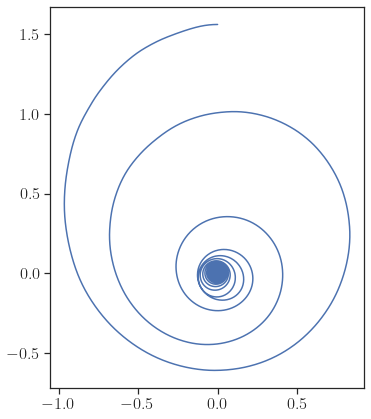

In [187]:
time, mass, pos, vel = reduce_data(data, Ntrunc=N_trunc[isim])
mtot = mass.sum(axis=1) 
dpos = pos[:,1] - pos[:,0]
dvel = vel[:,1] - vel[:,0] 
f, ax = plt.subplots(1,1, figsize=(7,7))
ax.set_aspect("equal")

ax.plot(dpos[:,0], dpos[:,1])

In [188]:
from scipy.signal import argrelextrema

semi, ecc = semi_ecc(dpos, dvel, mtot)
sep = (dpos*dpos).sum(axis=1)**0.5

peris = argrelextrema(sep, np.less, order=10)[0]
apos  = argrelextrema(sep, np.greater, order=10)[0]

rp = sep[peris]
ra = sep[apos]

print(len(rp), len(ra))

132 137


In [189]:
it = 0
iaex = ipex = 0
e_l, t_l = [], []
while True:
    if iaex == len(apos) or ipex == len(peris): break
    
    # Apo to peri
    while True:
        idx_apo = apos[iaex]
        idx_peri = peris[ipex]

        tapo = time[idx_apo]
        tperi = time[idx_peri]

        if tperi > tapo:
            e = (sep[idx_apo] - sep[idx_peri]) / (sep[idx_apo] + sep[idx_peri])
            t = (time[idx_apo] + time[idx_peri])/2
            e_l.append(e)
            t_l.append(t)
            break
        else:
            ipex+=1
            continue
    
    while True:
        idx_apo_next = apos[iaex+1]
        tapo_next = time[idx_apo_next]

        if tperi < tapo_next:
            e = (sep[idx_apo_next] - sep[idx_peri]) / (sep[idx_apo_next] + sep[idx_peri])
            t = (time[idx_apo_next] + time[idx_peri])/2
            e_l.append(e)
            t_l.append(t)
            break
        else:
            iaex+=1
            continue

    ipex+=1
    iaex+=1
#print(e_l, t_l)

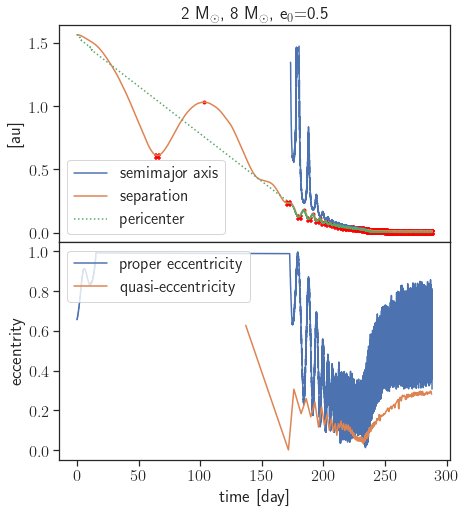

In [190]:
f, ax = plt.subplots(2, 1, figsize=(7,8), sharex=True)

f.subplots_adjust(hspace=0)

afilt = (semi>0) & (semi < 1.5)
apofilt = (semi>0) & (semi < 10)
ax[0].plot(time[afilt], semi[afilt], label="semimajor axis")
ax[0].set_title("2 M$_\odot$, 8 M$_\odot$, e$_0$={:g}".format(dictecc[isim]))
ax[0].plot(time, sep, label="separation")
ax[0].plot(time[apofilt], semi[apofilt]*(1-ecc[apofilt]), label="pericenter", ls=":")
ax[0].scatter(time[peris], sep[peris], c="red", marker="X")
ax[0].scatter(time[apos], sep[apos], c="red", marker=".")
ax[0].set_ylabel("[au]")
ax[0].legend()

ax[1].plot(time[semi>0], ecc[semi>0], label="proper eccentricity")
ax[1].plot(t_l, e_l, label="quasi-eccentricity")
ax[1].set_xlabel("time [day]")
ax[1].set_ylabel("eccentrity")
ax[1].legend(loc="upper left")


#plt.savefig("8R2G-{:g}.png".format(dictecc[isim]))
plt.show()

In [191]:
m1, m2 = 8 | units.MSun, 2 | units.MSun
ome0 = np.pi/2
nu0 = np.pi
mu = (m1 + m2)*constants.G

iapo = sep[0]/rsun_to_au
e0 = dictecc[isim] - 0.05
a0 = iapo / (1 + e0) | units.RSun

a1 = 1 | units.RSun
X = 0.1
l, k = 2, 1
CEvolve = MacegaPhaseEvolve(l=l, k=k, limit_radius=200, evolve_g=True)
C_l2k0, Lex, Tex = MacegaPhaseEvolve.C_from_X(X, mu, a0, l=l, k=k)
CEvolve.initialize_system(m1, m2, a0, e0, ome0, nu0, C=C_l2k0, a1=a1, lambd=25)
t, a, e, ome, nu, g = CEvolve.run_system(tfin=CEvolve.Period0*4, dt_out=CEvolve.Period0*0.0001)
#a = a *rsun_to_au
print(g)
r = a*(1-e*e) / (1 + e*np.cos(nu))

Using generic functions
Mass units: 2.54495602902e-09 MSun
C units: length**0 * time**0
C = 0.0318309886184 in none
Period0 = 0.353868940152 yr
Eps_ce/Eps0 230.854194377
B0: 3.95256844396e+17
[   1.            1.            1.         ...,  609.26289302  609.28855488
  609.31423588]


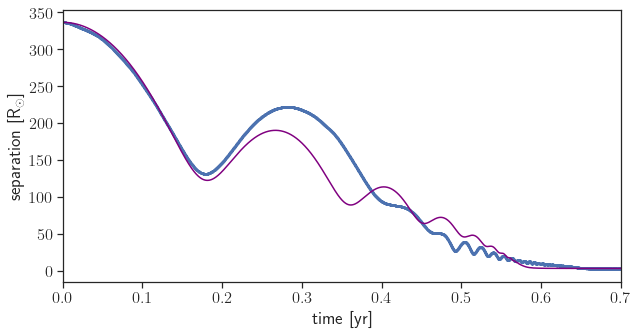

In [192]:
f, ax = plt.subplots(1, figsize=(10,5), sharex=True)
ax.plot(t, r, c="purple")
ax.scatter(time*day_to_yr, sep/rsun_to_au, marker=".", s=3, label="e$_0$=0.95")
ax.set_xlim(left=0.0, right=0.7)
ax.set_xlabel("time [yr]")
ax.set_ylabel("separation [R$_\odot$]")
dataplot1 = [t, r, time*day_to_yr, sep/rsun_to_au]
plt.show()

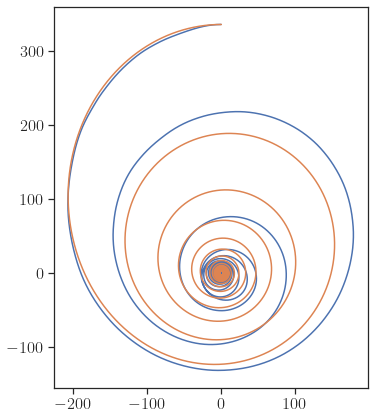

In [193]:
f, ax = plt.subplots(1,1, figsize=(7,7))
ax.set_aspect("equal")

ax.plot(dpos[:,0]/rsun_to_au, dpos[:,1]/rsun_to_au)
ax.plot((r*np.cos(np.pi+ome+nu)), (r*np.sin(np.pi+ome+nu)))

# isim = 0

In [196]:
isim = 3
data = pd.read_csv(datafold+csvfs[isim])
time, mass, pos, vel = reduce_data(data, Ntrunc=N_trunc[isim])
mtot = mass.sum(axis=1) 
dpos = pos[:,1] - pos[:,0]
dvel = vel[:,1] - vel[:,0]
sep = (dpos*dpos).sum(axis=1)**0.5
print("e0", dictecc[isim])

e0 0.0


In [197]:
m1, m2 = 8 | units.MSun, 2 | units.MSun
ome0 = np.pi/2
nu0 = np.pi
mu = (m1 + m2)*constants.G

iapo = sep[0]/rsun_to_au
#e0 = dictecc[isim]
#a0 = iapo / (1 + e0) | units.RSun
e0 = 0.3
a0 = 45.5 / (1 + e0) | units.RSun

a1 = 1 | units.RSun
X = 0.043
l, k = 2, 1
CEvolve = MacegaPhaseEvolve(l=l, k=k, limit_radius=30, evolve_g=True)
C_l2k0, Lex, Tex = MacegaPhaseEvolve.C_from_X(X, mu, a0, l=l, k=k)
CEvolve.initialize_system(m1, m2, a0, e0, ome0, nu0, C=C_l2k0, a1=a1, lambd=35)
t, a, e, ome, nu, g = CEvolve.run_system(tfin=CEvolve.Period0*7, dt_out=CEvolve.Period0*0.01)
#a = a *rsun_to_au
#print(g)
r = a*(1-e*e) / (1 + e*np.cos(nu))

Using generic functions
Mass units: 2.54495602902e-09 MSun
C units: length**0 * time**0
C = 0.013687325105902998 in none
Period0 = 0.020754968398001183 yr
Eps_ce/Eps0 34.0
B0: 2.82326317425e+17


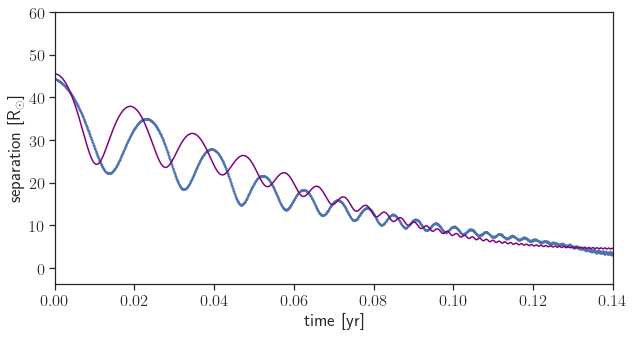

In [198]:
f, ax = plt.subplots(1, figsize=(10,5), sharex=True)
ax.plot(t, r, c="purple")
ax.scatter(time*day_to_yr-0.084, sep/rsun_to_au, marker=".", s=3, label="e$_0$=0.95")
ax.set_xlim(left=0.0, right=0.14)
ax.set_ylim(top=60)
ax.set_xlabel("time [yr]")
ax.set_ylabel("separation [R$_\odot$]")
dataplot2 = [t, r, time*day_to_yr-0.084, sep/rsun_to_au]
plt.show()

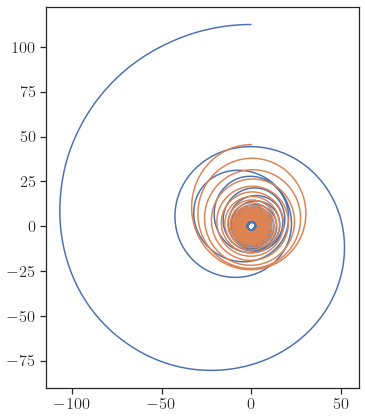

In [199]:
f, ax = plt.subplots(1,1, figsize=(7,7))
ax.set_aspect("equal")

ax.plot(dpos[:,0]/rsun_to_au, dpos[:,1]/rsun_to_au)
ax.plot((r*np.cos(np.pi+ome+nu)), (r*np.sin(np.pi+ome+nu)))

# Plots

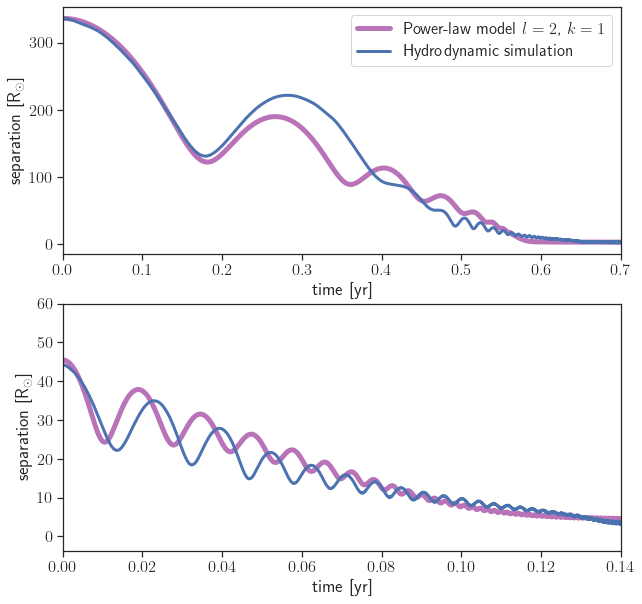

In [214]:
f, ax = plt.subplots(2, figsize=(10,10))

ax[0].plot(dataplot1[0], dataplot1[1], c="purple", lw=5, alpha=0.55, label="Power-law model $l=2$, $k=1$")
ax[0].plot(dataplot1[2], dataplot1[3], lw=3, label="Hydrodynamic simulation")
ax[0].set_xlim(left=0.0, right=0.7)
ax[0].set_xlabel("time [yr]")
ax[0].set_ylabel("separation [R$_\odot$]")
ax[0].legend()

# 2
ax[1].plot(dataplot2[0], dataplot2[1], c="purple", lw=5, alpha=0.55)
ax[1].plot(dataplot2[2], dataplot2[3], lw=3, label="e$_0$=0.95")
ax[1].set_xlim(left=0.0, right=0.14)
ax[1].set_ylim(top=60)
ax[1].set_xlabel("time [yr]")
ax[1].set_ylabel("separation [R$_\odot$]")
plt.savefig("hydrocomp.pdf")
plt.show()

# Ignore below

In [19]:
# Hila Glanz data
datafold = "../../CEdata/"
sepfile = "cesep_datasets.csv"
eccfile = "ceecc_datasets.csv"

In [30]:
sepdf = pd.read_csv(datafold+sepfile)
eccdf = pd.read_csv(datafold+eccfile)
#eccdf

alist = [3000, 276.7, 830, 1660]
elist = [0.5, 0.7, 0.9, 0.95]

In [31]:
from macega_phasevol import MacegaPhaseEvolve
from amuse.units import units, constants

isim=0
iapo = sepdf["bluey"][0]
e0 = elist[isim]
a0 = iapo / (1 + e0) | units.RSun


m1, m2 = 1 | units.MSun, 0.6 | units.MSun
ome0 = np.pi/2
nu0 = np.pi
mu = (m1 + m2)*constants.G

a1 = 40 | units.RSun
X = 0.05

Using generic functions
Mass units: 2.54495602902e-09 MSun
C units: length**3 * time**0
C = 159716971.619 3.36427433875e+26 * m**3
Period0 = 25.1029919179 yr
Eps_ce/Eps0 52.9241929223
B0: 1.92996506053e+15
a/adot = -0.00760297 Periods


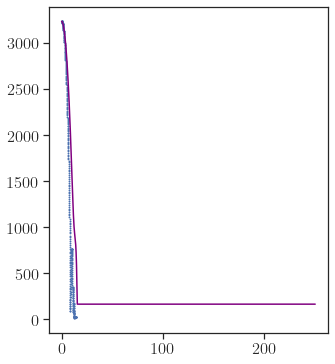

In [32]:
#### SECULAR 
l, k = 2, 4
CEvolve = MacegaPhaseEvolve(l=l, k=k)
C_l2k0, Lex, Tex = MacegaPhaseEvolve.C_from_X(X, mu, a0, l=l, k=k)
CEvolve.initialize_system(m1, m2, a0, e0, ome0, nu0, C=C_l2k0, a1=a1)
t, a, e, ome, nu, g = CEvolve.run_system(tfin=CEvolve.Period0*10, dt_out=CEvolve.Period0*0.001)
#a = a *rsun_to_au
r = a*(1-e*e) / (1 + e*np.cos(nu))


f, ax = plt.subplots(1, figsize=(5,6), sharex=True)
ax.plot(t, r, c="purple")
ax.scatter(sepdf["bluex"]*day_to_yr, sepdf["bluey"], marker=".", s=3, label="e$_0$=0.95")

plt.show()



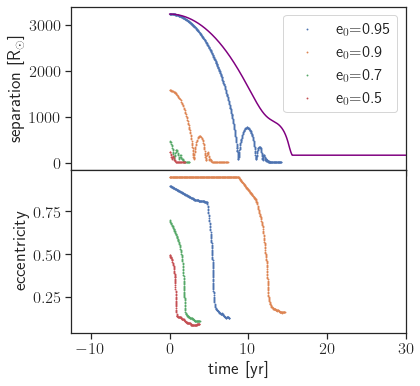

In [33]:
f, ax = plt.subplots(2, figsize=(6,6), sharex=True)
f.subplots_adjust(hspace=0)

ax[0].plot(t, r, c="purple")
maxt=30

ax[0].scatter(sepdf["bluex"]*day_to_yr, sepdf["bluey"], marker=".", s=3, label="e$_0$=0.95")
ax[0].scatter(sepdf["yellowx"]*day_to_yr, sepdf["yellowy"], marker=".", s=3, label="e$_0$=0.9")
ax[0].scatter(sepdf["orangex"]*day_to_yr, sepdf["orangey"], marker=".", s=3, label="e$_0$=0.7")
ax[0].scatter(sepdf["cyanx"]*day_to_yr, sepdf["cyany"], marker=".", s=3, label="e$_0$=0.5")
ax[0].legend()
ax[0].set_ylabel("separation [R$_\odot$]")
ax[0].set_xlim(right=maxt)

ax[1].scatter(eccdf["bluex"]*day_to_yr, eccdf["bluey"], marker=".", s=3, label="e$_0$=0.95")
ax[1].scatter(eccdf["yellowx"]*day_to_yr, eccdf["yellowy"], marker=".", s=3, label="e$_0$=0.9")
ax[1].scatter(eccdf["orangex"]*day_to_yr, eccdf["orangey"], marker=".", s=3, label="e$_0$=0.7")
ax[1].scatter(eccdf["cyanx"]*day_to_yr, eccdf["cyany"], marker=".", s=3, label="e$_0$=0.5")
ax[1].set_ylabel("eccentricity")
ax[1].set_xlabel("time [yr]")
ax[1].set_xlim(right=maxt)

plt.show()

